# Regularization and Evaluation of Neural Networks

In [1]:
from sklearn.datasets import load_sample_images
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.wrappers import scikit_learn
from tensorflow.keras.callbacks import EarlyStopping

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
%load_ext autoreload
%autoreload 2

## Learning Objectives

- use `keras` to code up a neural network model;
- explain dropout and early stopping as distinctive forms of regularization in neural networks;
- use wrappers inside `keras` to make models that can jibe with `sklearn`.

### From last time

In [2]:
digits = load_digits()
X = digits.data
y = digits.target

y_binary = y % 2

In [3]:
model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(X, y_binary, epochs=50, batch_size=10)

2022-07-28 14:03:15.061039: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-28 14:03:15.062793: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 10. Tune using inter_op_parallelism_threads for best performance.


Train on 1797 samples
Epoch 1/50
1797/1797 [==============================] - 1s 574us/sample - loss: 0.8493 - accuracy: 0.6934
Epoch 2/50
1797/1797 [==============================] - 0s 157us/sample - loss: 0.2612 - accuracy: 0.9054
Epoch 3/50
1797/1797 [==============================] - 0s 170us/sample - loss: 0.2203 - accuracy: 0.9160
Epoch 4/50
1797/1797 [==============================] - 0s 147us/sample - loss: 0.1921 - accuracy: 0.9226
Epoch 5/50
1797/1797 [==============================] - 0s 148us/sample - loss: 0.1711 - accuracy: 0.9366
Epoch 6/50
1797/1797 [==============================] - 0s 163us/sample - loss: 0.1485 - accuracy: 0.9421 - loss: 0.1506 - accuracy: 0.94
Epoch 7/50
1797/1797 [==============================] - 0s 159us/sample - loss: 0.1310 - accuracy: 0.9499
Epoch 8/50
1797/1797 [==============================] - 0s 186us/sample - loss: 0.1086 - accuracy: 0.9622
Epoch 9/50
1797/1797 [==============================] - ETA: 0s - loss: 0.0981 - accuracy: 0.96 - 

### Things to know:

- The data and labels in `fit()` need to be numpy arrays, not `pandas` dfs.
- Scaling your data will have a large impact on your model.
   > For our traditional input features, we would use a scaler object. For images, as long as the minimum value is 0, we can simply divide through by the maximum pixel intensity.

#### Getting data ready for modeling
**Preprocessing**:

- use train_test_split to create X_train, y_train, X_test, and y_test
- Split training data into pure_train and validation sets.
- Scale the pixel intensity to a value between 0 and 1.

Scaling our input variables will help speed up our neural network.

Since our minimum intensity is 0, we can normalize the inputs by dividing each value by the max value (16).

In [4]:
X_train, X_test, y_train, y_test =\
    train_test_split(X, y_binary, random_state=42, test_size=0.2)

X_pure_train, X_val, y_pure_train, y_val =\
    train_test_split(X_train, y_train, random_state=42, test_size=0.2)

#Normalize our inputs
X_pure_train, X_val, X_test = X_pure_train/16, X_val/16, X_test/16

For activation, let's start with the familiar sigmoid function, and see how it performs.

In [5]:
model = Sequential()
# We will start with our trusty sigmoid function.
# What does input dimension correspond to?
model.add(Dense(12, activation='sigmoid', input_dim=64))
model.add(Dense(8, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='SGD' ,
              # We use binary_crossentropy for a binary loss function
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Assign the variable history to store the results,
# and set verbose=1 so we can see the output. To see
# only the metrics at the end of each epoch, set verbose=2.
results = model.fit(X_pure_train, y_pure_train, epochs=10, batch_size=100, verbose=1)

Train on 1149 samples
Epoch 1/10
1149/1149 [==============================] - 0s 342us/sample - loss: 0.6961 - accuracy: 0.4961
Epoch 2/10
1149/1149 [==============================] - 0s 19us/sample - loss: 0.6958 - accuracy: 0.4961
Epoch 3/10
1149/1149 [==============================] - 0s 19us/sample - loss: 0.6955 - accuracy: 0.4970
Epoch 4/10
1149/1149 [==============================] - 0s 17us/sample - loss: 0.6953 - accuracy: 0.4961
Epoch 5/10
1149/1149 [==============================] - 0s 18us/sample - loss: 0.6951 - accuracy: 0.4961
Epoch 6/10
1149/1149 [==============================] - 0s 17us/sample - loss: 0.6949 - accuracy: 0.4891
Epoch 7/10
1149/1149 [==============================] - 0s 28us/sample - loss: 0.6947 - accuracy: 0.4795
Epoch 8/10
1149/1149 [==============================] - 0s 27us/sample - loss: 0.6945 - accuracy: 0.4761
Epoch 9/10
1149/1149 [==============================] - 0s 24us/sample - loss: 0.6944 - accuracy: 0.4691
Epoch 10/10
1149/1149 [=========

We can access the history of our model via `results.history`.
Use __dict__ to take a tour.

In [6]:
results.__dict__

{'validation_data': None,
 'model': <tensorflow.python.keras.engine.sequential.Sequential at 0x7f9b7085ce50>,
 '_chief_worker_only': None,
 'params': {'batch_size': 100,
  'epochs': 10,
  'steps': 12,
  'samples': 1149,
  'verbose': 1,
  'do_validation': False,
  'metrics': ['loss', 'accuracy']},
 'epoch': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 'history': {'loss': [0.6961276982534025,
   0.6957932904142209,
   0.6955352861845981,
   0.6952731135723589,
   0.6950878978709328,
   0.6948570340897748,
   0.6946513171918087,
   0.6945195922756112,
   0.694393779372422,
   0.6942653699581056],
  'accuracy': [0.49608356,
   0.49608356,
   0.49695387,
   0.49608356,
   0.49608356,
   0.48912096,
   0.47954744,
   0.47606614,
   0.46910357,
   0.4577894]}}

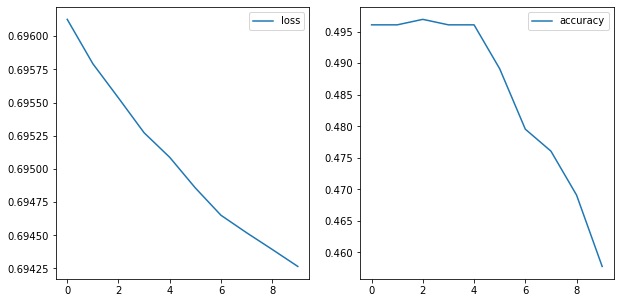

In [11]:
#Let's plot our loss and accuracy on two graphs
sigmoid_loss = results.history['loss']
sigmoid_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
sns.lineplot(x=results.epoch, y=sigmoid_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=sigmoid_accuracy, ax=ax2, label='accuracy');

We have two plots above both relating to the quality of our model.  The left-hand plot is our loss. It uses the probabilities associated with our predictions to judge how well our prediction fits reality. We want it to decrease as far as possible.

The accuracy judges how well the predictions are after applying the threshold at the output layer.  We want accuracy to increase.

If we look at our loss, it is still decreasing. That is a signal that our model is **still learning**. If our model is still learning, we can allow it to get better by turning a few dials.

Let's:
- increase the number of epochs;
- change sigmoid activation in the hidden layers to ReLU; and
- decrease the batch size.

In [12]:
X_pure_train.shape[0]

1149

This below code is currently what we already ran above.

How can we change it to accomplish the above bullet points?

In [13]:
#Modify the code below

model = Sequential()
# We will start with our trusty sigmoid function.
# What does input dimension correspond to?
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='SGD' ,
              # We use binary_crossentropy for a binary loss function
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Assign the variable history to store the results,
# and set verbose=1 so we can see the output. To see
# only the metrics at the end of each epoch, set verbose=2.
results = model.fit(X_pure_train, y_pure_train, epochs=100, batch_size=32, verbose=1)

Train on 1149 samples
Epoch 1/100
1149/1149 [==============================] - 0s 386us/sample - loss: 0.7410 - accuracy: 0.4578
Epoch 2/100
1149/1149 [==============================] - 0s 41us/sample - loss: 0.7023 - accuracy: 0.4813
Epoch 3/100
1149/1149 [==============================] - 0s 46us/sample - loss: 0.6821 - accuracy: 0.5692
Epoch 4/100
1149/1149 [==============================] - 0s 47us/sample - loss: 0.6663 - accuracy: 0.6266
Epoch 5/100
1149/1149 [==============================] - 0s 48us/sample - loss: 0.6526 - accuracy: 0.6675
Epoch 6/100
1149/1149 [==============================] - 0s 62us/sample - loss: 0.6395 - accuracy: 0.6902
Epoch 7/100
1149/1149 [==============================] - 0s 45us/sample - loss: 0.6259 - accuracy: 0.7241
Epoch 8/100
1149/1149 [==============================] - 0s 50us/sample - loss: 0.6114 - accuracy: 0.7415
Epoch 9/100
1149/1149 [==============================] - 0s 58us/sample - loss: 0.5957 - accuracy: 0.7668
Epoch 10/100
1149/1149 

1149/1149 [==============================] - 0s 42us/sample - loss: 0.1847 - accuracy: 0.9182
Epoch 78/100
1149/1149 [==============================] - 0s 46us/sample - loss: 0.1849 - accuracy: 0.9182
Epoch 79/100
1149/1149 [==============================] - 0s 46us/sample - loss: 0.1836 - accuracy: 0.9173
Epoch 80/100
1149/1149 [==============================] - 0s 45us/sample - loss: 0.1841 - accuracy: 0.9217
Epoch 81/100
1149/1149 [==============================] - 0s 45us/sample - loss: 0.1819 - accuracy: 0.9173
Epoch 82/100
1149/1149 [==============================] - 0s 45us/sample - loss: 0.1814 - accuracy: 0.9182
Epoch 83/100
1149/1149 [==============================] - 0s 46us/sample - loss: 0.1807 - accuracy: 0.9225
Epoch 84/100
1149/1149 [==============================] - 0s 44us/sample - loss: 0.1791 - accuracy: 0.9217
Epoch 85/100
1149/1149 [==============================] - 0s 44us/sample - loss: 0.1793 - accuracy: 0.9199
Epoch 86/100
1149/1149 [==========================

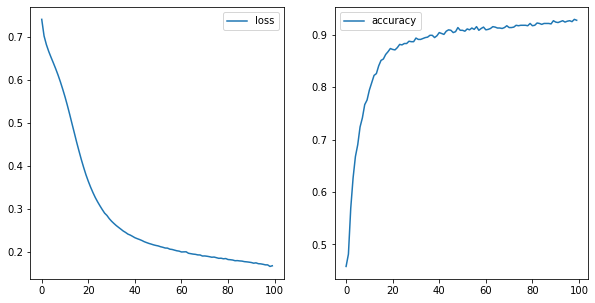

In [14]:
sigmoid_loss = results.history['loss']
sigmoid_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=sigmoid_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=sigmoid_accuracy, ax=ax2, label='accuracy');

If we increase the learning rate to a very high number, we see that our model overshoots the minimum, and starts bouncing all around.

Train on 1149 samples
Epoch 1/30
1149/1149 [==============================] - 1s 475us/sample - loss: 1.6292 - accuracy: 0.4917
Epoch 2/30
1149/1149 [==============================] - 0s 125us/sample - loss: 0.9885 - accuracy: 0.4978
Epoch 3/30
1149/1149 [==============================] - 0s 133us/sample - loss: 1.0134 - accuracy: 0.4874
Epoch 4/30
1149/1149 [==============================] - 0s 139us/sample - loss: 0.9972 - accuracy: 0.5039
Epoch 5/30
1149/1149 [==============================] - 0s 133us/sample - loss: 0.9536 - accuracy: 0.5065
Epoch 6/30
1149/1149 [==============================] - 0s 161us/sample - loss: 0.9361 - accuracy: 0.5152
Epoch 7/30
1149/1149 [==============================] - 0s 146us/sample - loss: 0.9836 - accuracy: 0.5022
Epoch 8/30
1149/1149 [==============================] - 0s 147us/sample - loss: 1.0511 - accuracy: 0.4813
Epoch 9/30
1149/1149 [==============================] - 0s 144us/sample - loss: 0.9880 - accuracy: 0.4970
Epoch 10/30
1149/1149 [=

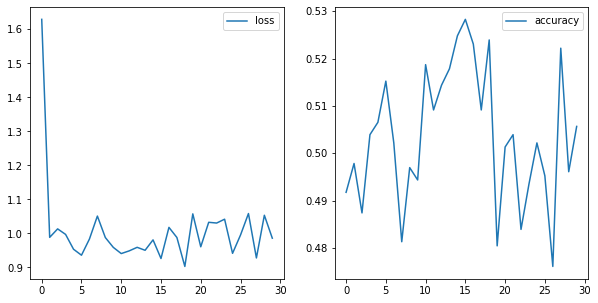

In [16]:
#Modify the code below

model = Sequential()

sgd = SGD(lr=9) #Stochastic Gradient Descent optimizer. 
#its default learning rate is 0.01
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=sgd,#Note what we do differently here, 
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train,
                    epochs=30, batch_size=10, verbose=1)

relu_loss = results.history['loss']
relu_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=relu_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=relu_accuracy, ax=ax2, label='accuracy');

### Exercise

We have been looking only at our training set. Let's add in our validation set to the picture. Check the docstring for the `.fit()` method and add in our validation data.

Train on 1149 samples, validate on 288 samples
Epoch 1/100
1149/1149 [==============================] - 1s 624us/sample - loss: 0.6682 - accuracy: 0.5213 - val_loss: 0.6266 - val_accuracy: 0.6215
Epoch 2/100
1149/1149 [==============================] - 0s 84us/sample - loss: 0.5944 - accuracy: 0.6719 - val_loss: 0.5512 - val_accuracy: 0.7222
Epoch 3/100
1149/1149 [==============================] - 0s 81us/sample - loss: 0.5310 - accuracy: 0.7781 - val_loss: 0.4956 - val_accuracy: 0.8333
Epoch 4/100
1149/1149 [==============================] - 0s 79us/sample - loss: 0.4874 - accuracy: 0.8433 - val_loss: 0.4581 - val_accuracy: 0.8611
Epoch 5/100
1149/1149 [==============================] - 0s 90us/sample - loss: 0.4533 - accuracy: 0.8782 - val_loss: 0.4323 - val_accuracy: 0.8785
Epoch 6/100
1149/1149 [==============================] - 0s 79us/sample - loss: 0.4306 - accuracy: 0.8982 - val_loss: 0.4093 - val_accuracy: 0.8889
Epoch 7/100
1149/1149 [==============================] - 0s 78us

Epoch 56/100
1149/1149 [==============================] - 0s 70us/sample - loss: 0.0992 - accuracy: 0.9965 - val_loss: 0.1386 - val_accuracy: 0.9792
Epoch 57/100
1149/1149 [==============================] - 0s 66us/sample - loss: 0.0969 - accuracy: 0.9974 - val_loss: 0.1334 - val_accuracy: 0.9792
Epoch 58/100
1149/1149 [==============================] - 0s 72us/sample - loss: 0.0952 - accuracy: 0.9974 - val_loss: 0.1379 - val_accuracy: 0.9757
Epoch 59/100
1149/1149 [==============================] - 0s 66us/sample - loss: 0.0927 - accuracy: 0.9974 - val_loss: 0.1345 - val_accuracy: 0.9792
Epoch 60/100
1149/1149 [==============================] - 0s 69us/sample - loss: 0.0908 - accuracy: 0.9965 - val_loss: 0.1339 - val_accuracy: 0.9792
Epoch 61/100
1149/1149 [==============================] - 0s 67us/sample - loss: 0.0879 - accuracy: 0.9965 - val_loss: 0.1346 - val_accuracy: 0.9757
Epoch 62/100
1149/1149 [==============================] - 0s 72us/sample - loss: 0.0863 - accuracy: 0.9965

<AxesSubplot:>

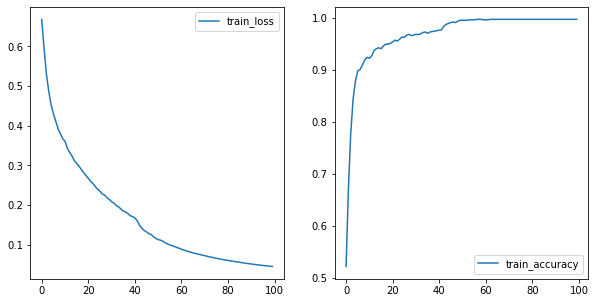

In [29]:
model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

## Insert your code here for our new fit call
results = model.fit(X_pure_train, y_pure_train, validation_data=(X_val, y_val), epochs=100, batch_size=32)

train_loss = results.history['loss']
train_acc = results.history['accuracy']
#Insert code here to see the validation results


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

#Insert code here to plot the validation results


<AxesSubplot:>

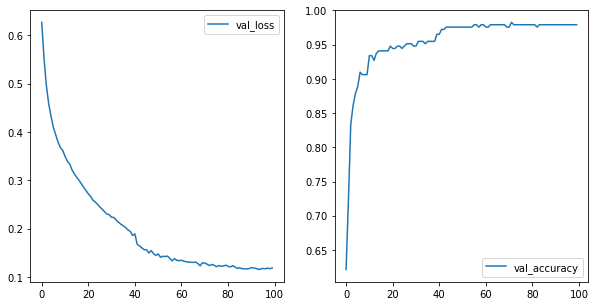

In [31]:
val_loss = results.history['val_loss']
val_accuracy = results.history['val_accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_accuracy, ax=ax2, label='val_accuracy')

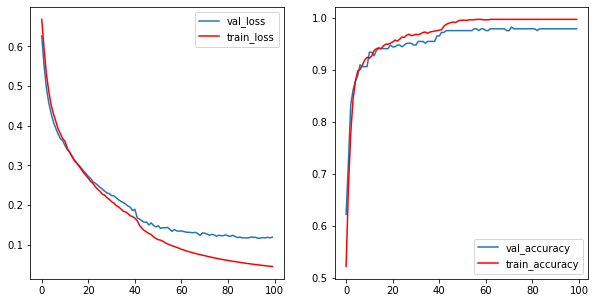

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss', color='red')
sns.lineplot(x=results.epoch, y=val_accuracy, ax=ax2, label='val_accuracy')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy', color='red');

<details>
    <summary>One answer here</summary>
<code>model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
results = model.fit(X_pure_train, y_pure_train,
                   validation_data=(X_val, y_val),
                   epochs=30, batch_size=10)
train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')
sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');</code>
</details>

In [21]:
results.history['val_accuracy'][-1]

0.9826389

## Connecting with `sklearn`

The `keras.wrappers` submodule means that we can turn `keras` models into estimators that `sklearn` tools will recognize.

In [22]:
# This will throw an error.

cross_val_score(model, X_pure_train, y_pure_train)

TypeError: If no scoring is specified, the estimator passed should have a 'score' method. The estimator <tensorflow.python.keras.engine.sequential.Sequential object at 0x7f9b70992a10> does not.

In [23]:
#Set up our build function
def build_model():
    model=Sequential()
    model.add(Dense(12, activation='relu', input_dim=64))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(4, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [24]:
#Set up an estimator our sklearn tools can recognize
keras_model = scikit_learn.KerasClassifier(build_model, epochs=30, batch_size=32, verbose=2)

In [25]:
type(keras_model)

tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier

In [26]:
cross_val_score(keras_model, X_pure_train, y_pure_train)

Train on 919 samples
Epoch 1/30
919/919 - 1s - loss: 0.6809 - accuracy: 0.5277
Epoch 2/30
919/919 - 0s - loss: 0.6433 - accuracy: 0.7062
Epoch 3/30
919/919 - 0s - loss: 0.6084 - accuracy: 0.7367
Epoch 4/30
919/919 - 0s - loss: 0.5703 - accuracy: 0.7726
Epoch 5/30
919/919 - 0s - loss: 0.5252 - accuracy: 0.8139
Epoch 6/30
919/919 - 0s - loss: 0.4840 - accuracy: 0.8520
Epoch 7/30
919/919 - 0s - loss: 0.4188 - accuracy: 0.8945
Epoch 8/30
919/919 - 0s - loss: 0.3384 - accuracy: 0.9086
Epoch 9/30
919/919 - 0s - loss: 0.2796 - accuracy: 0.9195
Epoch 10/30
919/919 - 0s - loss: 0.2387 - accuracy: 0.9271
Epoch 11/30
919/919 - 0s - loss: 0.2150 - accuracy: 0.9314
Epoch 12/30
919/919 - 0s - loss: 0.1956 - accuracy: 0.9336
Epoch 13/30
919/919 - 0s - loss: 0.1789 - accuracy: 0.9391
Epoch 14/30
919/919 - 0s - loss: 0.1717 - accuracy: 0.9434
Epoch 15/30
919/919 - 0s - loss: 0.1617 - accuracy: 0.9423
Epoch 16/30
919/919 - 0s - loss: 0.1519 - accuracy: 0.9423
Epoch 17/30
919/919 - 0s - loss: 0.1470 - ac

Epoch 16/30
920/920 - 0s - loss: 0.1410 - accuracy: 0.9413
Epoch 17/30
920/920 - 0s - loss: 0.1339 - accuracy: 0.9467
Epoch 18/30
920/920 - 0s - loss: 0.1388 - accuracy: 0.9424
Epoch 19/30
920/920 - 0s - loss: 0.1271 - accuracy: 0.9446
Epoch 20/30
920/920 - 0s - loss: 0.1252 - accuracy: 0.9489
Epoch 21/30
920/920 - 0s - loss: 0.1159 - accuracy: 0.9467
Epoch 22/30
920/920 - 0s - loss: 0.1125 - accuracy: 0.9511
Epoch 23/30
920/920 - 0s - loss: 0.1086 - accuracy: 0.9554
Epoch 24/30
920/920 - 0s - loss: 0.1031 - accuracy: 0.9565
Epoch 25/30
920/920 - 0s - loss: 0.1007 - accuracy: 0.9554
Epoch 26/30
920/920 - 0s - loss: 0.0978 - accuracy: 0.9587
Epoch 27/30
920/920 - 0s - loss: 0.0938 - accuracy: 0.9576
Epoch 28/30
920/920 - 0s - loss: 0.0897 - accuracy: 0.9630
Epoch 29/30
920/920 - 0s - loss: 0.0857 - accuracy: 0.9630
Epoch 30/30
920/920 - 0s - loss: 0.0830 - accuracy: 0.9641
229/1 - 0s - loss: 0.1386 - accuracy: 0.9345


array([0.96086955, 0.9173913 , 0.95652175, 0.95652175, 0.93449783])

## Regularization

Does regularization make sense in the context of neural networks? <br/>

Yes! We still have all of the salient ingredients: a loss function, overfitting vs. underfitting, and coefficients (weights) that could get too large.

But there are now a few different flavors besides L1 and L2 regularization. (Note that L1 regularization is not common in the context of  neural networks.)

We'll add a few more layers to give regularization a better chance of making a difference!

Modify the below cell to add regularization to one layer

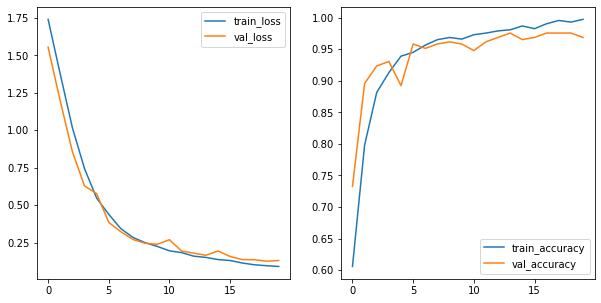

In [28]:
model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))

# We can add L2 (or L1) regularization right into
# the layer with the kernel_regularizer parameter.

#Modify code here to add in regularization to this layer
model.add(Dense(20, activation='relu', kernel_regularizer=l2(l=0.05)))

# Note that there is also a bias_regularizer,
# but this tends to have less effect.

model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train, epochs=20, batch_size=32,
                    verbose=0, validation_data=(X_val, y_val))

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

Adding L2 to multiple layers:

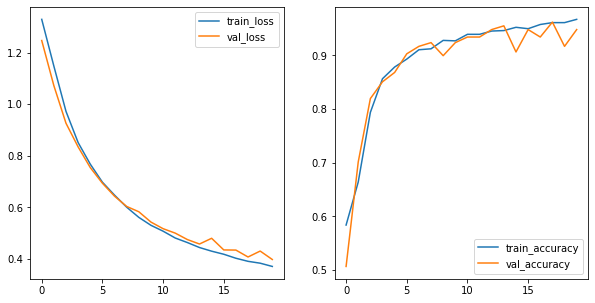

In [33]:
model = Sequential()
model.add(Dense(30, activation='relu',
                input_dim=64))
model.add(Dense(20, activation='relu',
                kernel_regularizer=l2(l=0.01)))

model.add(Dense(12, activation='relu',
                kernel_regularizer=l2(l=0.01)))
model.add(Dense(12, activation='relu',
                kernel_regularizer=l2(l=0.01)))
model.add(Dense(12, activation='relu',
                kernel_regularizer=l2(l=0.01)))
model.add(Dense(8, activation='relu',
                kernel_regularizer=l2(l=0.01)))
model.add(Dense(4, activation='relu',
                kernel_regularizer=l2(l=0.01)))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train, epochs=20, batch_size=32,
                    verbose=0, validation_data=(X_val, y_val))

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

### Dropout

We can also specify a dropout layer in keras, which randomly shuts off different nodes during training. This can help to prevent overfitting.

![drop_out](images/drop_out.png)

### Exercise

To add dropout to a `keras` network, simply add it as though it were a layer. It will apply to the immediately preceding layer.

Add Dropout to one or more layers below.

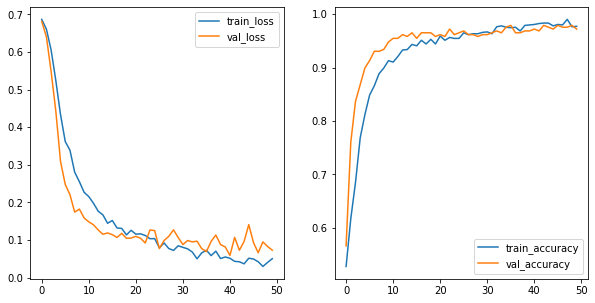

In [34]:
#Adjust the code to add dropout

model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train, epochs=50,
                    batch_size= 32, verbose=0,
                    validation_data=(X_val, y_val))

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

<details>
    <summary>One answer here</summary>
<code>model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(12, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train, epochs=50,
                    batch_size= 32, verbose=0,
                    validation_data=(X_val, y_val))

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');</code>
</details>

In [35]:
results.history['val_accuracy'][-1]

0.9722222

### Early Stopping

We can also tell our neural network to stop once it stops realizing any gain.

Here we tell it to stop once a very small positive change in the validation loss occurs:

Epoch 00018: early stopping


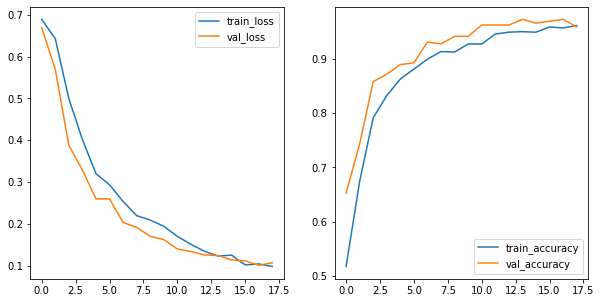

In [36]:
model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define the EarlyStopping object
early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-8,
                           verbose=1,
                           mode='min')

# Place this in a list as the value of the `callbacks` parameter
# in the `.fit()` method.
results = model.fit(X_pure_train, y_pure_train,
                    epochs=20, batch_size=32,
                    verbose=0, validation_data=(X_val, y_val),
                    callbacks=[early_stop])

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

### Exercise

That probably stopped too early. We can specify the number of epochs in which it doesn't see decrease in the loss with the `patience` parameter. Modify the code below to include an Early Stop with a patience of 5 epochs.

Epoch 00034: early stopping


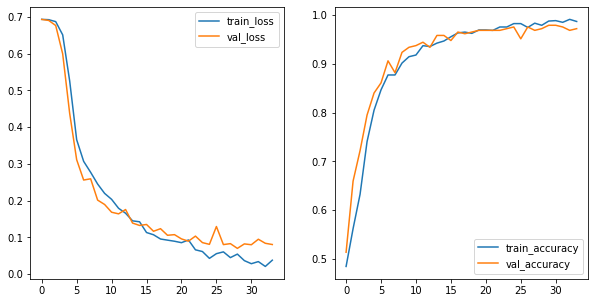

In [37]:
#Modify the code to include an Early stop with a patience of 5 epochs

model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define the EarlyStopping object
early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-8, verbose=1, patience=5, mode='min')

# Place this in a list as the value of the `callbacks` parameter
# in the `.fit()` method.
results = model.fit(X_pure_train, y_pure_train,
                    epochs=50, batch_size= 32,
                    verbose=0, validation_data=(X_val, y_val),
                   callbacks=[early_stop])

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

<details>
    <summary>One answer here</summary>
<code>model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-8,
                           verbose=1, patience=5,
                           mode='min')   
results = model.fit(X_pure_train, y_pure_train,
                    epochs=50, batch_size= 32,
                    verbose=0, validation_data=(X_val, y_val),
                    callbacks=[early_stop])
train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');</code>
</details>

In [38]:
results.history['val_accuracy'][-1]

0.9722222

## Multiclass Classification and Softmax

Now let's return to the problem of predicting digits 0 through 9.

In [39]:
digits = load_digits()
X = digits.data
y = digits.target

In [40]:
y

array([0, 1, 2, ..., 8, 9, 8])

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42,
                                                    test_size=0.2)
X_pure_train, X_val, y_pure_train, y_val =\
    train_test_split(X_train, y_train,
                     random_state=42, test_size=0.2)
X_pure_train, X_val, X_test = X_pure_train/16, X_val/16, X_test/16

For a multiclass output, our neural net expects our target to be in a certain form.

In [42]:
y_pure_train

array([8, 7, 4, ..., 1, 2, 8])

In [43]:
y_pure_train.shape

(1149,)

In [46]:
y_pure_train.reshape(-1,1).shape

(1149, 1)

In [47]:
y_pure_train.reshape(-1,1)

array([[8],
       [7],
       [4],
       ...,
       [1],
       [2],
       [8]])

In [48]:
ohe = OneHotEncoder(sparse=False)
y_pure_train = ohe.fit_transform(y_pure_train.reshape(-1,1))
y_val = ohe.transform(y_val.reshape(-1,1))
y_test = ohe.transform(y_test.reshape(-1,1))

In [49]:
y_pure_train

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [55]:
# Model from above, but now with ten output neurons:

model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train,
                   epochs=50, batch_size=10,
                   validation_data=(X_val, y_val))

Train on 1149 samples, validate on 288 samples
Epoch 1/50
1149/1149 [==============================] - 1s 999us/sample - loss: 2.2741 - accuracy: 0.1549 - val_loss: 2.2040 - val_accuracy: 0.1771
Epoch 2/50
1149/1149 [==============================] - 0s 187us/sample - loss: 2.1047 - accuracy: 0.2689 - val_loss: 2.0085 - val_accuracy: 0.3542
Epoch 3/50
1149/1149 [==============================] - 0s 170us/sample - loss: 1.8443 - accuracy: 0.4308 - val_loss: 1.6876 - val_accuracy: 0.4653
Epoch 4/50
1149/1149 [==============================] - 0s 177us/sample - loss: 1.5305 - accuracy: 0.5248 - val_loss: 1.4028 - val_accuracy: 0.5556
Epoch 5/50
1149/1149 [==============================] - 0s 156us/sample - loss: 1.2329 - accuracy: 0.6562 - val_loss: 1.1239 - val_accuracy: 0.7083
Epoch 6/50
1149/1149 [==============================] - 0s 163us/sample - loss: 0.9761 - accuracy: 0.7685 - val_loss: 0.9206 - val_accuracy: 0.7812
Epoch 7/50
1149/1149 [==============================] - 0s 176us/

In [ ]:
1.2 2.3 5.6 7.2 3.4 

e^(1.2)/(e^1.2 + e^2.3 + e^5.6 + e^7.2 + e^3.4) = probability of first class
e^(2.3) / that sum = probability of second class
e^(5.6) / that sum = probability of 3rd class

$$\large \text{Softmax}(x_{i}) = \frac{\exp(x_i)}{\sum_j \exp(x_j)}$$

The sofmax function outputs a number between 0 and 1 for each of our classes.  All of the probabilities of the classes sum up to 1.

The number of nodes in our output layer equals the number of categories in our dataset.

We also need a new loss function: **categorical crossentropy**, which calculates a separate loss for each label and then sums the results.

In [56]:
history = results.history
training_loss = history['loss']
val_loss = history['val_loss']
training_accuracy = history['accuracy']
val_accuracy = history['val_accuracy']

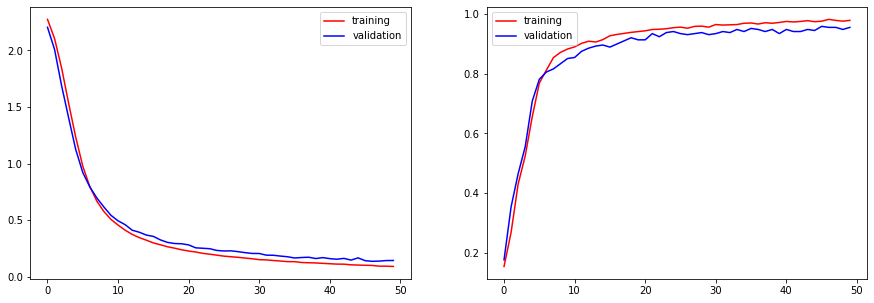

In [57]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))


sns.lineplot(x=list(range(len(training_loss))),
             y=training_loss, color='r', label='training', ax=ax1)
sns.lineplot(x=list(range(len(val_loss))),
             y=val_loss, color='b', label='validation', ax=ax1)
sns.lineplot(x=list(range(len(training_loss))),
             y=training_accuracy, color='r', label='training',ax=ax2)
sns.lineplot(x=list(range(len(val_loss))),
             y=val_accuracy, color='b', label='validation',ax=ax2)
ax1.legend();

In [58]:
model.predict(X_test)

array([[4.1979939e-02, 1.9078469e-05, 7.8508130e-08, ..., 1.6162488e-09,
        1.1561469e-02, 1.4400773e-05],
       [4.7875827e-05, 1.4625077e-05, 6.5031576e-09, ..., 2.0958109e-05,
        4.4944542e-04, 9.9843484e-01],
       [1.8663184e-09, 8.6468413e-07, 5.6487072e-04, ..., 2.7996994e-05,
        2.3521981e-04, 4.3998287e-05],
       ...,
       [1.0299425e-03, 1.2273766e-01, 3.0789117e-04, ..., 5.7664007e-04,
        7.5127381e-01, 1.2256183e-01],
       [4.7958491e-04, 5.2090254e-06, 4.1372380e-03, ..., 8.7986464e-08,
        4.3008529e-02, 6.4127515e-03],
       [1.3793870e-05, 4.6798002e-07, 1.0273981e-06, ..., 1.4149748e-06,
        9.5705800e-03, 2.8749164e-02]], dtype=float32)

In [59]:
#Get the predictions on our test set
y_hat_test = np.argmax(model.predict(X_test), axis=-1)

In [60]:
y_hat_test

array([6, 9, 3, 7, 2, 1, 5, 2, 5, 3, 1, 9, 4, 0, 4, 2, 3, 7, 8, 8, 4, 3,
       9, 7, 5, 6, 3, 5, 6, 3, 4, 9, 1, 4, 4, 6, 9, 4, 7, 6, 6, 9, 1, 3,
       6, 1, 3, 0, 6, 5, 5, 1, 9, 5, 6, 0, 9, 0, 0, 1, 7, 4, 5, 2, 4, 5,
       7, 0, 7, 5, 9, 5, 5, 4, 7, 0, 4, 5, 5, 9, 9, 0, 2, 3, 8, 0, 6, 4,
       4, 9, 1, 2, 8, 3, 5, 2, 9, 4, 4, 4, 4, 3, 5, 3, 1, 3, 5, 9, 4, 2,
       7, 7, 4, 4, 1, 9, 2, 7, 8, 7, 2, 6, 9, 4, 0, 7, 2, 7, 5, 8, 7, 5,
       7, 9, 0, 6, 6, 4, 2, 8, 0, 9, 4, 6, 9, 9, 6, 9, 0, 5, 5, 6, 6, 0,
       6, 4, 2, 9, 3, 9, 7, 2, 9, 0, 4, 5, 3, 6, 5, 9, 9, 8, 4, 2, 1, 3,
       7, 7, 2, 2, 3, 9, 8, 0, 3, 2, 2, 5, 6, 9, 9, 4, 1, 5, 4, 2, 3, 6,
       4, 8, 5, 9, 5, 7, 1, 9, 4, 8, 1, 5, 4, 4, 9, 6, 1, 8, 6, 0, 4, 5,
       2, 7, 4, 6, 4, 5, 6, 0, 3, 2, 3, 6, 7, 1, 9, 1, 4, 7, 6, 5, 2, 5,
       5, 1, 0, 2, 8, 8, 9, 7, 7, 6, 2, 2, 2, 3, 4, 8, 8, 3, 6, 0, 3, 7,
       7, 0, 1, 0, 4, 5, 1, 5, 3, 6, 0, 4, 1, 0, 0, 3, 6, 5, 9, 7, 3, 5,
       5, 9, 9, 8, 5, 3, 3, 2, 0, 5, 8, 3, 4, 0, 2,

In [61]:
y_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [63]:
y_test_restore

array([[6],
       [9],
       [3],
       [7],
       [2],
       [1],
       [5],
       [2],
       [5],
       [2],
       [1],
       [9],
       [4],
       [0],
       [4],
       [2],
       [3],
       [7],
       [8],
       [8],
       [4],
       [3],
       [9],
       [7],
       [5],
       [6],
       [3],
       [5],
       [6],
       [3],
       [4],
       [9],
       [1],
       [4],
       [4],
       [6],
       [9],
       [4],
       [7],
       [6],
       [6],
       [9],
       [1],
       [3],
       [6],
       [1],
       [3],
       [0],
       [6],
       [5],
       [5],
       [1],
       [9],
       [5],
       [6],
       [0],
       [9],
       [0],
       [0],
       [1],
       [0],
       [4],
       [5],
       [2],
       [4],
       [5],
       [7],
       [0],
       [7],
       [5],
       [9],
       [5],
       [5],
       [4],
       [7],
       [0],
       [4],
       [5],
       [5],
       [9],
       [9],
       [0],
       [2],
    

In [62]:
y_test_restore = ohe.inverse_transform(y_test)
confusion_matrix(y_test_restore, y_hat_test)

array([[31,  0,  0,  0,  1,  0,  0,  1,  0,  0],
       [ 0, 28,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 32,  1,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  1, 32,  0,  1,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 46,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 45,  1,  0,  0,  1],
       [ 1,  0,  0,  0,  0,  0, 34,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 33,  0,  1],
       [ 0,  1,  1,  0,  0,  1,  0,  0, 27,  0],
       [ 0,  0,  0,  1,  0,  0,  0,  1,  0, 38]])

Wow, look at that performance!  

That is great, but remember, we were dealing with simple black and white images.  With color, our basic neural net will have less success.

We will explore more advanced tools in the coming days.
